# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any)

In [ ]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 23.2 MB/s eta 0:

In [ ]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np
import pickle
import gdown
import random

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]


# Tokenization
tokenizer.fit_on_texts(corpus)
#print(tokenizer.word_index['<unk>'])

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']
#print(eos)
#print(tokenizer.index_word[sos])

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets.
* shuffled_data contains scrumbled sequences, and will be the input to the model.
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [ ]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 279, 28, 279, 18, 1992, 1007, 3]
shuffled sentecen:  [2, 1007, 18, 28, 279, 1992, 279, 3]


Let us look at detokenized data:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> she is a living legend who has been performing for over 50 years all over the world <end>
shuffled sentence:  <start> all years performing for 50 who over is she over the legend a living world has been <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [ ]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [ ]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

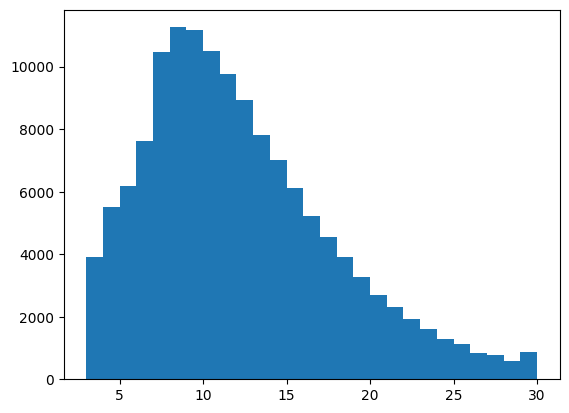

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

The model implemented in this code is a type of Transformer model, more specifically a sequence-to-sequence (seq2seq) architecture that leverages the concept of attention mechanism. Transformers have been widely used in many natural language processing tasks, such as text translation, generation, and summarization due to their ability to focus on different parts of the input sequence when generating an output. Here's a step-by-step explanation of this Transformer model:

Hyperparameters: The model starts with defining a set of hyperparameters, which are the configuration settings used for model training. The hyperparameters here include vocabulary size, maximum sequence length, embedding dimensions, number of attention heads, size of Feed Forward Network (FFN) units, dropout rate, learning rate, and number of layers in the Transformer encoder.

Transformer Encoder: The function transformer_encoder is then defined, which builds a single layer of the Transformer encoder. The encoder layer includes two main sub-layers: a multi-head self-attention mechanism, and a position-wise feed-forward network (FFN). Each of these sub-layers has a residual connection around it followed by a layer normalization. The dropout technique is used for regularization to prevent overfitting.

Model Architecture: The model architecture consists of an encoder and a decoder. The encoder first applies an embedding layer to the input, followed by multiple layers of the Transformer encoder defined earlier. The decoder also applies an embedding layer to its input and uses the same number of Transformer encoder layers. Then, an attention layer is applied to the decoder's output and the encoder's output. The outputs of the attention layer and the decoder are then concatenated and fed to a Dense layer, which uses a softmax activation function to predict the output.

Model Compilation: The model is then compiled using the RMSProp optimizer, with a learning rate as defined earlier. The loss function used is 'sparse categorical crossentropy', which is suitable for multi-class classification problems. The model also uses accuracy as a metric to evaluate its performance.

The summary of the model provides a layer-by-layer description of the architecture, including the output shape and the number of parameters of each layer.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import regularizers

# Model hyperparameters
vocab_size = 10000 + 4
max_sequence_len = max([len(x) for x in original_data])
embed_dim = 100
num_heads = 5
ffn_units = 2048
dropout_rate = 0.1
learning_rate = 0.001
num_layers = 5


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Network
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu',
                               kernel_regularizer=regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=embed_dim, kernel_size=1,
                               kernel_regularizer=regularizers.l2(0.01))(x)
    return x + res

# Encoder Input
encoder_inputs = Input(shape=(None,))
enc_padding_mask = tf.keras.layers.Lambda(
    lambda seq: tf.cast(tf.math.equal(seq, 0), 'float32'),
    output_shape=(None, 1, 1, None),
    name='enc_padding_mask')(encoder_inputs)

# Encoder Embedding
enc_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)(encoder_inputs)

# Encoder Transformer
for _ in range(num_layers):
    enc_emb = transformer_encoder(enc_emb, embed_dim // num_heads, num_heads, ffn_units, dropout_rate)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_padding_mask = tf.keras.layers.Lambda(
    lambda seq: tf.cast(tf.math.equal(seq, 0), 'float32'),
    output_shape=(None, 1, 1, None),
    name='dec_padding_mask')(decoder_inputs)

# Decoder Embedding
dec_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)(decoder_inputs)

# Decoder Transformer
for _ in range(num_layers):
    dec_emb = transformer_encoder(dec_emb, embed_dim // num_heads, num_heads, ffn_units, dropout_rate)

# Attention layer
attention = tf.keras.layers.Attention()([dec_emb, enc_emb])
dec_concat = tf.keras.layers.Concatenate(axis=-1)([dec_emb, attention])

# Dense layer to predict output
outputs = Dense(vocab_size, activation='softmax')(dec_concat)

# Define the model
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

# Compile the model
optimizer = RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    1000400     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, None, 100)    1000400     ['input_1[0][0]']                
                                                                                              

In this project, due to encountered memory constraints, the model training was divided into two separate sessions. Each session consisted of 20 epochs. This strategy helped to effectively manage the available computational resources, especially given the limiting factor of memory. The training state, including model weights and optimizer status, was saved and reloaded for each session to ensure a seamless continuation of the training process.

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Early stopping
checkpoint = ModelCheckpoint('BestResult.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Model fitting with early stopping
history = model.fit([c_train, x_train], y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2,
          callbacks=[checkpoint])

Epoch 1/20
1202/1202 [==============================] - ETA: 0s - loss: 2.7798 - accuracy: 0.6860
Epoch 1: val_loss improved from inf to 1.78454, saving model to BestResult.h5
1202/1202 [==============================] - 199s 134ms/step - loss: 2.7798 - accuracy: 0.6860 - val_loss: 1.7845 - val_accuracy: 0.7180
Epoch 2/20
1202/1202 [==============================] - ETA: 0s - loss: 1.6488 - accuracy: 0.7265
Epoch 2: val_loss improved from 1.78454 to 1.53908, saving model to BestResult.h5
1202/1202 [==============================] - 131s 109ms/step - loss: 1.6488 - accuracy: 0.7265 - val_loss: 1.5391 - val_accuracy: 0.7348
Epoch 3/20
1202/1202 [==============================] - ETA: 0s - loss: 1.4566 - accuracy: 0.7415
Epoch 3: val_loss improved from 1.53908 to 1.38954, saving model to BestResult.h5
1202/1202 [==============================] - 130s 108ms/step - loss: 1.4566 - accuracy: 0.7415 - val_loss: 1.3895 - val_accuracy: 0.7490
Epoch 4/20
1202/1202 [==============================]

In [ ]:
history = model.fit([c_train, x_train], y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2,
          callbacks=[checkpoint])

Epoch 1/20
1202/1202 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.8131
Epoch 1: val_loss improved from 0.97533 to 0.97153, saving model to BestResult.h5
1202/1202 [==============================] - 143s 119ms/step - loss: 0.7389 - accuracy: 0.8131 - val_loss: 0.9715 - val_accuracy: 0.7873
Epoch 2/20
1202/1202 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.8154
Epoch 2: val_loss did not improve from 0.97153
1202/1202 [==============================] - 130s 108ms/step - loss: 0.7227 - accuracy: 0.8154 - val_loss: 0.9746 - val_accuracy: 0.7849
Epoch 3/20
1202/1202 [==============================] - ETA: 0s - loss: 0.7075 - accuracy: 0.8176
Epoch 3: val_loss improved from 0.97153 to 0.96243, saving model to BestResult.h5
1202/1202 [==============================] - 128s 107ms/step - loss: 0.7075 - accuracy: 0.8176 - val_loss: 0.9624 - val_accuracy: 0.7872
Epoch 4/20
1202/1202 [==============================] - ETA: 0s - loss: 0.6935 - acc

In [ ]:
model.save('MyBestResult.h5')

# Metrics

In [ ]:
from difflib import SequenceMatcher
import numpy as np

def score(s, p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return match.size / len(s)


In this section of the project, the trained model is used to generate predictions on the test set. Due to the large size of the data, the predictions are made in chunks of 1000 at a time, to manage memory usage efficiently. Each predicted chunk is translated from token sequences back to sentences and stored for subsequent evaluation.

Once all predictions have been made, these predicted sentences undergo post-processing to remove specific tokens used during training ("<start>" and "<end>"). The actual y_test sequences are also translated back to sentences and cleaned in a similar fashion.

To evaluate the model's performance, a custom scoring function is used. This function computes a similarity score between each pair of actual and predicted sentences. The mean of these scores is then calculated to obtain the average score, which serves as the final performance metric for the model.

For this particular model, the average score on the test set was found to be approximately 0.643. This suggests that on average, the model has a moderate level of accuracy in generating predictions that match the actual sentences in the test set.

In [ ]:
# Determine the number of predictions to make at once
pred_chunk_size = 1000

# Prepare to store predictions
accumulated_predictions = []

# Make predictions in chunks
for j in range(0, len(x_test), pred_chunk_size):
    # Prepare decoder input for the current chunk
    curr_decoder_input = np.zeros((len(x_test[j:j+pred_chunk_size]), max_sequence_len))

    # Generate predictions for the current chunk
    curr_predictions = model.predict([x_test[j:j+pred_chunk_size], curr_decoder_input])

    # Translate predictions to token sequences
    pred_token_sequences = np.argmax(curr_predictions, axis=-1)

    # Convert token sequences to sentences
    predicted_sentences_chunk = [tokenizer.sequences_to_texts([sequence])[0] for sequence in pred_token_sequences]

    # Collect current chunk's predictions
    accumulated_predictions.extend(predicted_sentences_chunk)

# Clean up all generated predictions, remove <start> and <end> tags
accumulated_predictions = [sentence.replace('<start> ', '').replace(' <end>', '') for sentence in accumulated_predictions]

# Convert actual y_test sequences to sentences
real_sentences = [tokenizer.sequences_to_texts([sequence])[0] for sequence in y_test]
real_sentences = [sentence.replace('<start> ', '').replace(' <end>', '') for sentence in real_sentences]

# Calculate scores for each prediction
comparison_scores = [score(real, predicted) for real, predicted in zip(real_sentences, accumulated_predictions)]

# Compute the average score
avg_score = np.mean(comparison_scores)

print("The average score on the test set is", avg_score)


6/6 [==============================] - 0s 20ms/step
The average score on the test set is 0.6432713308627612


Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1.

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/len(p))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!